<a href="https://colab.research.google.com/github/jeonniga/-/blob/master/dqn_recsys_Getting_Started.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pre Setup
You ideally should have pytorch pre installed with google colab


In [1]:
from IPython.display import clear_output

! git clone https://github.com/awarebayes/RecNN
! pip install -r ./RecNN/requirements.txt
! pip install ./RecNN
! pip install gdown

clear_output()

In [2]:
! wget http://files.grouplens.org/datasets/movielens/ml-20m.zip
! gdown https://drive.google.com/uc?id=1EQ_zXBR3DKpmJR3jBgLvt-xoOvArGMsL
! unzip ml-20m.zip
clear_output()

## Pandas backends

You can get better loading speed performance if you use Modin.
It does not come with recnn by default so you have to install it. 

It will not affect the performance in a google colab notebook, but if your pc has plenty of cores, it will.

In [ ]:
# !pip install modin[ray]
# recnn.pd.set("modin")

## Restart runtime
Dont panic if it says "Your session crashed". Run and jump over to "Getting started section"

In [ ]:
import os
os.kill(os.getpid(), 9)

# Getting Started with recnn
This is my school project. It focuses on Reinforcement Learning for personalized news recommendation. The main distinction is that it tries to solve online off-policy learning with dynamically generated item embeddings. I want to create a library with SOTA algorithms for reinforcement learning recommendation, providing the level of abstraction you like. In this notebook, you can play around with library's key components.

P.S. this tutorial is available offline


Also some bugs may occure: tqdm.pandas import error

Go to runtime, click restart

In [1]:
from IPython.display import clear_output
import recnn

import torch
import torch.nn as nn
from tqdm.auto import tqdm
import torch_optimizer as optim

# Environments

Main abstraction of the library for datasets is called environment, similar to how other reinforcement
learning libraries name it. This interface is created to provide SARSA like input for your RL Models. When you are working with recommendation env, you have two choices: using static length inputs (say 10 items) or dynamic length time series with sequential encoders (many to one rnn). Static length is provided via FrameEnv, and dynamic length along with sequential state representation encoder is implemented in SeqEnv. Let’s take a look at FrameEnv first:

In order to initialize an env, you need to provide embeddings and ratings directories.
You can also use caching.

In [2]:
frame_size = 10
batch_size = 25
# embeddgings: https://drive.google.com/open?id=1EQ_zXBR3DKpmJR3jBgLvt-xoOvArGMsL
dirs = recnn.data.env.DataPath(
    base="",
    embeddings="ml20_pca128.pkl",
    ratings="ml-20m/ratings.csv",
    cache="cached_frame_env.pkl", # cache will generate after you run
    use_cache=True
)
env = recnn.data.env.FrameEnv(dirs, frame_size, batch_size)

You can get train and test batches directly from the environmnent

In [4]:
train = env.train_batch()
test = env.train_batch()
state, action, reward, next_state, done = recnn.data.get_base_batch(train, device=torch.device('cpu'))

In [5]:
print(state)

tensor([[  6.0919,  -1.2394,   1.1477,  ...,   5.0000,   5.0000,   5.0000],
        [  5.8175,  -1.2590,  -9.0728,  ...,   5.0000,   5.0000,   5.0000],
        [  3.1487,   3.3241, -12.5570,  ...,   5.0000,   5.0000,   5.0000],
        ...,
        [  5.0938,  -1.5238,  -5.7540,  ...,  -2.0000,   4.0000,   1.0000],
        [  6.3019,  -6.2144,  -1.8957,  ...,   4.0000,   1.0000,   2.0000],
        [  3.6832,  -1.0374,  -7.8407,  ...,   1.0000,   2.0000,   2.0000]])


You can also look at the metadata:
    user ids and their positions

In [6]:
train['meta']

{'sizes': tensor([ 236,  199,  214,  532,   70, 1474,   69,   37,   39,   30,   80,   70,
           29,   44,   21,   74,   22,  130,   23,   29,   20,  203,  255,  237,
          282]),
 'users': tensor([ 45451,  33570,  80914,  76741,  53800,  49229, 125875,  99666,  27891,
          21545,  77765,  91899,   7776, 111255,  41133,  39113,    197, 133708,
          26048, 118842, 103729, 120089,  36593,  67495, 106622])}

## Working with metadata
you can display user_id: their item/rating positions in the batch

In [7]:
import numpy as np
user_ends = np.cumsum(train['meta']['sizes']).numpy().tolist() + [0]
user_starts = [0] + user_ends
starts_ends = list(zip(user_starts, user_ends))[:-1]
user_range = dict(zip(train['meta']['users'].numpy(), starts_ends))
user_range

{197: (3218, 3240),
 7776: (3050, 3079),
 21545: (2870, 2900),
 26048: (3370, 3393),
 27891: (2831, 2870),
 33570: (236, 435),
 36593: (3645, 3900),
 39113: (3144, 3218),
 41133: (3123, 3144),
 45451: (0, 236),
 49229: (1251, 2725),
 53800: (1181, 1251),
 67495: (3900, 4137),
 76741: (649, 1181),
 77765: (2900, 2980),
 80914: (435, 649),
 91899: (2980, 3050),
 99666: (2794, 2831),
 103729: (3422, 3442),
 106622: (4137, 4419),
 111255: (3079, 3123),
 118842: (3393, 3422),
 120089: (3442, 3645),
 125875: (2725, 2794),
 133708: (3240, 3370)}

# Recommending

Let's initialize main networks, and recommend something!

In [8]:
value_net  = recnn.nn.Critic(1290, 128, 256, 54e-2)
policy_net = recnn.nn.Actor(1290, 128, 256, 6e-1)

In [9]:
recommendation = policy_net(state)
value = value_net(state, recommendation)
print(recommendation)
print(value)

tensor([[ -0.0429,   4.0228,   4.6988,  ...,   4.4322,  -0.6010,  -5.3859],
        [ -2.9168,   3.1831,  -9.1667,  ...,   3.1363,   6.8549,  -7.3664],
        [ -2.9340,  -4.4668,  -1.2368,  ...,   0.2389,  -9.8812,  -6.1002],
        ...,
        [ -1.6067,  -1.5906,  -3.9627,  ...,  -0.1376,  -3.7005, -10.7235],
        [ -5.1449,   1.4699,   0.9481,  ...,  -0.5809,  -2.2753,  -0.8915],
        [ -1.5316,   2.4869,  -0.8978,  ...,   0.5183,   6.2981,  -3.2225]],
       grad_fn=<AddmmBackward>)
tensor([[-1.4894],
        [-2.7197],
        [-4.3218],
        ...,
        [ 2.6723],
        [ 0.2003],
        [ 0.7195]], grad_fn=<AddmmBackward>)


# Algo classes

Algo is a high level abstraction for an RL algorithm. You need two networks (policy and value) in order to initialize it. Later on you can tweak parameters and stuff in the algo itself
.
#### Important: you can set writer to torch.SummaryWriter and get the debug output


## Tweak how you want
```
ddpg = recnn.nn.DDPG(policy_net, value_net)
print(ddpg.params)
ddpg.params['gamma'] = 0.9
ddpg.params['policy_step'] = 3
ddpg.optimizers['policy_optimizer'] = torch.optim.Adam(ddpg.nets['policy_net'], your_lr)
ddpg.writer = torch.utils.tensorboard.SummaryWriter('./runs')
ddpg = ddpg.to(torch.device('cuda'))
```

ddpg.loss_layout is also handy, it allows you to see how the loss should look like

In [10]:
# test function
def run_tests():
    batch = next(iter(env.test_dataloader))
    loss = ddpg.update(batch, learn=False)
    return loss

In [11]:
value_net  = recnn.nn.Critic(1290, 128, 256, 54e-2)
policy_net = recnn.nn.Actor(1290, 128, 256, 6e-1)

In [12]:
cuda = torch.device('cuda')
ddpg = recnn.nn.DDPG(policy_net, value_net)
ddpg = ddpg.to(cuda)
plotter = recnn.utils.Plotter(ddpg.loss_layout, [['value', 'policy']],)

step 1000


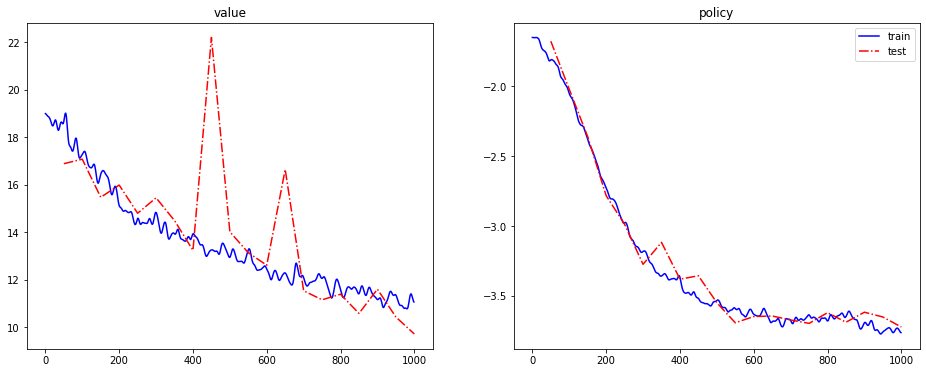

In [13]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

plot_every = 50
n_epochs = 2

def learn():
    for epoch in range(n_epochs):
        for batch in tqdm(env.train_dataloader):
            loss = ddpg.update(batch, learn=True)
            plotter.log_losses(loss)
            ddpg.step()
            if ddpg._step % plot_every == 0:
                clear_output(True)
                print('step', ddpg._step)
                test_loss = run_tests()
                plotter.log_losses(test_loss, test=True)
                plotter.plot_loss()
            if ddpg._step > 1000:
                return
            
learn()

if ImportError: cannot import name '_png':

Headbar -> Runtime -> Restart Runtime

Or: Contol+M


# Update Functions
## Here is what's going on inside algo class

In [14]:
value_net  = recnn.nn.Critic(1290, 128, 256, 54e-2)
policy_net = recnn.nn.Actor(1290, 128, 256, 6e-1)
# these are target networks that we need for ddpg algorigm to work
target_value_net = recnn.nn.Critic(1290, 128, 256)
target_policy_net = recnn.nn.Actor(1290, 128, 256)

target_policy_net.eval()
target_value_net.eval()


# soft update
recnn.utils.soft_update(value_net, target_value_net, soft_tau=1.0)
recnn.utils.soft_update(policy_net, target_policy_net, soft_tau=1.0)

# define optimizers
value_optimizer = optim.RAdam(value_net.parameters(),
                              lr=1e-5, weight_decay=1e-2)
policy_optimizer = optim.RAdam(policy_net.parameters(), lr=1e-5 , weight_decay=1e-2)

nets = {
    'value_net': value_net.to(cuda),
    'target_value_net': target_value_net.to(cuda),
    'policy_net': policy_net.to(cuda),
    'target_policy_net': target_policy_net.to(cuda),
}

optimizer = {
    'policy_optimizer': policy_optimizer,
    'value_optimizer':  value_optimizer
}

debug = {}
writer = recnn.utils.misc.DummyWriter()


In [15]:
step = 0
params = {
    'gamma'      : 0.99,
    'min_value'  : -10,
    'max_value'  : 10,
    'policy_step': 10,
    'soft_tau'   : 0.001,
}
batch = {'state': state, 'action': action, 'reward': reward, 'next_state': next_state, 'done':done}
loss = recnn.nn.update.ddpg_update(batch, params, nets, optimizer, cuda, debug, writer, step=step)
print(loss)

{'value': 13.708120346069336, 'policy': -1.1476987600326538, 'step': 0}


## Training Loop
Let's wrap this thing in the training loop. I also will use Colab's gpu for training.

In an error pops up, go to runtime -> change runtime type -> select GPU. And also restart the session.

In [16]:
cuda = torch.device('cuda')
loss = {
    'test': {'value': [], 'policy': [], 'step': []},
    'train': {'value': [], 'policy': [], 'step': []}
    }

plotter = recnn.utils.Plotter(loss, [['value', 'policy']],)

In [17]:
# test function
def run_tests():
    batch = next(iter(env.test_dataloader))
    loss = recnn.nn.ddpg_update(batch, params, nets, optimizer,
                       cuda, debug, writer, step=step, learn=False)
    return loss

step 1000


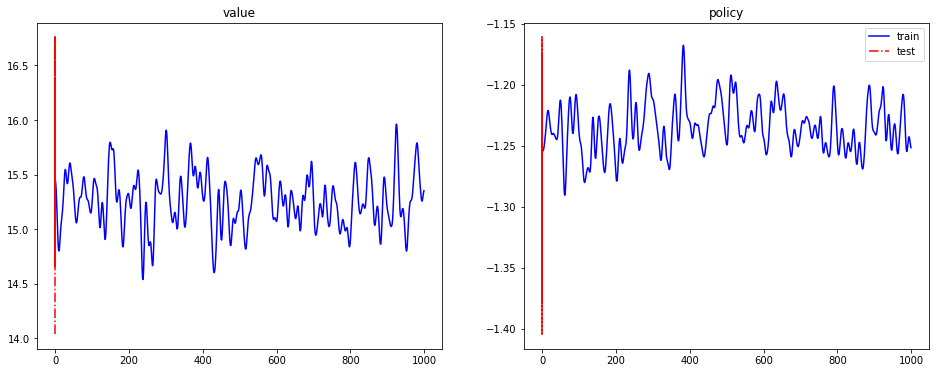

In [18]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

plot_every = 50
n_epochs = 2

def learn():
    step = 0
    for epoch in range(n_epochs):
        for batch in tqdm(env.train_dataloader):
            loss = recnn.nn.ddpg_update(batch, params,
                                               nets, optimizer, cuda, debug,
                                               writer, step=step)
            plotter.log_losses(loss)
            step += 1
            if step % plot_every == 0:
                clear_output(True)
                print('step', step)
                test_loss = run_tests()
                plotter.log_losses(test_loss, test=True)
                plotter.plot_loss()
            if step > 1000:
                return
            
        
learn()

In [19]:
def plot_grad_flow(named_parameters):
    ave_grads = []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            print('plotting', n)
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
    plt.plot(ave_grads, alpha=0.3, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, linewidth=1, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(xmin=0, xmax=len(ave_grads))
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)

plotting linear1.weight
plotting linear2.weight
plotting linear3.weight


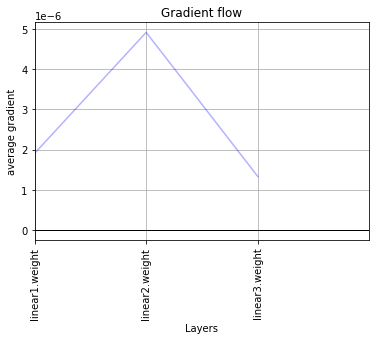

In [20]:
plot_grad_flow(ddpg.nets['policy_net'].named_parameters())

# Bonus: working with your own data
RecNN's main goal is to provide a wrapper for Markov Descision Process.

It literally does one thing: iterates over table with columns [item, user, rating, timestamp]

Anyways, here is how my preparedataset function looks like:

In [21]:
def prepare_dataset(args_mut, kwargs):

    """
        Basic prepare dataset function. Automatically makes index linear, in ml20 movie indices look like:
        [1, 34, 123, 2000], recnn makes it look like [0,1,2,3] for you.
    """

    # get args
    frame_size = kwargs.get('frame_size')
    key_to_id = args_mut.base.key_to_id
    df = args_mut.df

    # rating range mapped from [0, 5] to [-5, 5]
    df['rating'] = try_progress_apply(df['rating'], lambda i: 2 * (i - 2.5))
    # id's tend to be inconsistent and sparse so they are remapped here
    df['movieId'] = try_progress_apply(df['movieId'], lambda i: key_to_id.get(i))
    users = df[['userId', 'movieId']].groupby(['userId']).size()
    users = users[users > frame_size].sort_values(ascending=False).index

    if pd.get_type() == "modin":
        df = df._to_pandas() # pandas groupby is sync and doesnt affect performance
    ratings = df.sort_values(by='timestamp').set_index('userId').drop('timestamp', axis=1).groupby('userId')

    # groupby user
    user_dict = {}

    def app(x):
        userid = (x.index[0])
        user_dict[userid] = {}
        user_dict[userid]['items'] = x['movieId'].values
        user_dict[userid]['ratings'] = x['rating'].values

    # collect
    try_progress_apply(ratings, app)

    # set args
    args_mut.user_dict = user_dict
    args_mut.users = users

    return args_mut, kwargs

 Look up the docs: reference/data/dataset_functions for further details.

In [22]:
import pandas as pd
import numpy as np
import datetime
import random
import time

def random_string_date():
  return datetime.datetime.strptime('{} {} {} {}'.format(random.randint(1, 366),
                                                         random.randint(0, 23),
                                                         random.randint(1, 59),
                                                          2019), '%j %H %M %Y').strftime("%m/%d/%Y, %H:%M:%S")

def string_time_to_unix(s):
  return int(time.mktime(datetime.datetime.strptime(s, "%m/%d/%Y, %H:%M:%S").timetuple()))

size = 100000
n_emb = 1000
n_usr = 1000
mydf = pd.DataFrame({'book_id': np.random.randint(0, n_emb, size=size),
                     'reader_id': np.random.randint(1, n_usr, size=size),
                     'liked': np.random.randint(0, 2, size=size),
                     'when': [random_string_date() for i in range(size)]})
my_embeddings = dict([(i, torch.tensor(np.random.randn(128)).float()) for i in range(n_emb)])
mydf.head()

,book_id,reader_id,liked,when
0,820,512,1,"03/02/2019, 21:02:00"
1,62,835,0,"11/24/2019, 13:48:00"
2,485,653,1,"01/01/2020, 04:40:00"
3,566,938,1,"07/20/2019, 05:39:00"
4,51,743,0,"12/25/2019, 20:43:00"


In [23]:
! mkdir mydataset
import pickle

mydf.to_csv('mydataset/mydf.csv', index=False)
with open('mydataset/myembeddings.pickle', 'wb') as handle:
    pickle.dump(my_embeddings, handle)

In [24]:
   def prepare_my_dataset(args_mut, kwargs):

        # get args
        frame_size = kwargs.get('frame_size')
        key_to_id = args_mut.base.key_to_id
        df = args_mut.df

        df['liked'] = df['liked'].apply(lambda a: (a - 1) * (1 - a) + a)
        df['when'] = df['when'].apply(string_time_to_unix)
        df['book_id'] = df['book_id'].apply(key_to_id.get)

        users = df[['reader_id', 'book_id']].groupby(['reader_id']).size()
        users = users[users > frame_size].sort_values(ascending=False).index

        # If using modin: pandas groupby is sync and doesnt affect performance
        # if pd.get_type() == "modin": df = df._to_pandas()  
        ratings = df.sort_values(by='when').set_index('reader_id').drop('when', axis=1).groupby('reader_id')

        # Groupby user
        user_dict = {}

        def app(x):
            userid = x.index[0]
            user_dict[int(userid)] = {}
            user_dict[int(userid)]['items'] = x['book_id'].values
            user_dict[int(userid)]['ratings'] = x['liked'].values

        ratings.apply(app)

        args_mut.user_dict = user_dict
        args_mut.users = users

        return args_mut, kwargs

In [25]:
frame_size = 10
batch_size = 25


dirs = recnn.data.env.DataPath(
    base="mydataset/",
    embeddings="myembeddings.pickle",
    ratings="mydf.csv",
    cache="frame_env.pkl", # cache will generate after you run
    use_cache=True # generally you want to save env after it runs
)

env = recnn.data.env.FrameEnv(
    dirs,
    frame_size,
    batch_size, 
    prepare_dataset=prepare_my_dataset # <- ! pass YOUR function here
) 

# That's it!

Now let's use the library

step 75


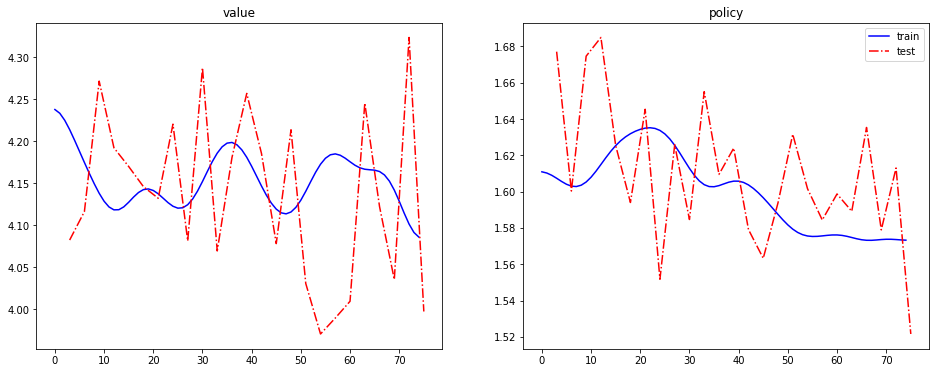

In [26]:
# test function
def run_tests():
    batch = next(iter(env.test_dataloader))
    loss = ddpg.update(batch, learn=False)
    return loss
  
value_net  = recnn.nn.Critic(1290, 128, 256, 54e-2)
policy_net = recnn.nn.Actor(1290, 128, 256, 6e-1)

cuda = torch.device('cuda')
ddpg = recnn.nn.DDPG(policy_net, value_net)
ddpg = ddpg.to(cuda)
plotter = recnn.utils.Plotter(ddpg.loss_layout, [['value', 'policy']],)

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

plot_every = 3
n_epochs = 2

def learn():
    for epoch in range(n_epochs):
        for batch in tqdm(env.train_dataloader):
            loss = ddpg.update(batch, learn=True)
            plotter.log_losses(loss)
            ddpg.step()
            if ddpg._step % plot_every == 0:
                clear_output(True)
                print('step', ddpg._step)
                test_loss = run_tests()
                plotter.log_losses(test_loss, test=True)
                plotter.plot_loss()
            if ddpg._step > 100:
                return
            
learn()

# Congratulations you've made it
Now you know how to use the library with your own data and is ready to apply it in your project. 

**Make sure to give it a star**